# **1. Introduction**
-------------------------------------------------------------------------------------
The challenge, organized by İş Bankası, involves examining a provided training dataset to perform all necessary operations and make predictions on a test dataset. The objective is to develop an artificial intelligence model using the usage data of a mobile application. The model's purpose is to recommend to each user the three menus they are most likely to need within the application. The dataset includes binary indicators for nine menus, and the task is to predict which three of these menus should be added to the user interface.

The evaluation metric for this challenge is the Jaccard Score. Predictions, consisting of nine binary values indicating whether each menu should be recommended or not, are compared to the ground truth using this metric.

A sample output might look like this:

* Customer A -> 000101010 (Predicted that Customer A should be recommended menus 4, 6, and 8.)

* Customer B -> 100000011 (Predicted that Customer B should be recommended menus 1, 8, and 9.)

> **Note:** *that predictions should only include three menus.*

In [1]:
# !pip install fastparquet

In [2]:
# !pip install iterative-stratification

# **2. Import Libraries**
----------------------
In this section, we start by importing crucial Python libraries that form the foundation of our machine learning project. These libraries provide a rich toolkit for data manipulation, model development, and evaluation. Let's take a closer look at the primary libraries and their roles:

>#### 1. **Pandas and NumPy**

- `pandas` and `numpy` are the cornerstone libraries for data manipulation and numerical operations, respectively. They provide the necessary tools to load, preprocess, and analyze the dataset.

>#### 2. **Warning Suppression**

To maintain code readability, we use the `warnings` library to suppress any warning messages. This ensures that the code output remains clean and focused.

>#### 3. **Scikit-Learn**

`scikit-learn` is a powerful machine learning library. We import components from it, including:

  - `jaccard_score` for creating custom evaluation metrics.
  - `train_test_split` to split the data into training and testing sets.
  - `IsolationForest` and `GaussianMixture` for anomaly detection.
  - `MultiLabelBinarizer` and `MinMaxScaler` for data preprocessing.
  
>#### 4. **XGBoost, LightGBM, and CatBoost**

- These are popular gradient boosting libraries that offer efficient and effective machine learning algorithms. They are commonly used for classification tasks and predictive modeling.

>#### 5. **Multi-Label Classification Tools**

To address multi-label classification challenges, we import various tools, including:

  - `ClassifierChain`
  - `LabelPowerset`
  - `BinaryRelevance`
  - `OneVsRestClassifier`
  - `MultilabelStratifiedKFold` for cross-validation.

>#### 6. **Optuna**

- `optuna` is a library used for hyperparameter optimization. It enables us to fine-tune model parameters to achieve optimal predictive performance.


We have established a robust foundation by importing these essential libraries, setting the stage for data preprocessing, modeling, and evaluation in our machine learning project.


In [3]:
# Import necessary libraries
import optuna
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter("ignore")

from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.multioutput import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset, BinaryRelevance
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Set display options for Pandas
pd.set_option("display.max_rows", 200) 
pd.set_option("display.max_columns", 300) 

# **2. Data Import**
------------
Data is loaded from Parquet files using the `pd.read_parquet` function. Three key data sources are imported:
- **Training Data**: This contains the primary data for model training.
- **Test Data**: This dataset will be used for model evaluation.
- **Submission Sample**: A sample of the submission format for this Kaggle competition.

In [4]:
train = pd.read_parquet('train_final.parquet', engine='fastparquet')
test = pd.read_parquet('test_final.parquet', engine='fastparquet')
submission = pd.read_parquet('submission_sample_final.parquet', engine='fastparquet')

# 3. **Configuration Class for Data Processing and Modeling Pipeline**
------
In this section, we define a dedicated configuration class, `CFG`, which serves as a central control point for various settings and options in our Menu Recommendation project. This class encapsulates a range of configurations to tailor the machine learning workflow to our specific needs. Let's delve into the key configurations within this class:

>#### 1. **Data Quality Checks**

- `check_data`: Set to `True` to perform data quality checks.
- `check_columns`: Set to `True` to check for column consistency.
- `null_values`: Set to `True` to check for null values in the data.

>#### 2. **Data Visualization**

- `box_plots`: Set to `True` to create box plots.
- `hist_plots`: Set to `True` to create histogram plots.
- `target_visualization`: Set to `True` to visualize the target variable.
- `menu_usage`: Set to `True` to perform menu usage visualization.
- `monthly_visualization`: Set to `True` to visualize data on a monthly basis.


>#### 3. **Data Preprocessing**

- `remove_carriers`: When set to `True`, it enables the removal of certain carriers and device brands to enhance data quality.
- `min_max_scaler`: If `True`, it activates feature scaling using Min-Max scaling.
- `extract_seconds`: Enabling this option triggers the extraction and transformation of time-related features.
- `extract_features`: When `True`, it allows for the creation of additional features based on existing ones.
- `target_binarizer`: If `True`, it involves binarization of the target variables.
- `gaussian_mixture`: Setting this to `True` enables Gaussian Mixture Modeling for feature extraction.
- `isolation_forest`: Enabling this option activates Isolation Forest for anomaly detection.

>#### 4. **Hyperparameter Optimization**

- `xgb_optuna`, `lgbm_optuna` and `catb_optuna`: These settings control the use of Optuna for hyperparameter optimization with the respective machine learning models.

>#### 5. **Multi-Label Classification Models**

- For each machine learning model (e.g., CatBoost, XGBoost), we have a set of configurations to choose the appropriate multi-label classification strategy. Options include `catb_classifier_Powerset`, `catb_classifier_Chain`, `catb_classifier_BRelevance`, and `catb_classifier_OneVsRest`.

- Similar configurations are available for XGBoost (`xgb_classifier_...`) and LGBM (`lgbm_classifier_...`) models.


>#### 6. **Cross-Validation and Prediction Flags**

- `cross_validation`: Set to `True` to perform cross-validation.
- `predict_test`: Set to `True` to make predictions on the test data.

This configuration class helps control the various steps and operations in your data processing and modeling pipeline based on the flags and parameters you set.


In [5]:
# Configuration class to set various flags and parameters
class CFG:
        
    # Data Quality Checks
    check_data = True          
    check_columns = True        
    null_values = True          

    # Data Visualization
    box_plots = True            
    hist_plots = True           
    target_visualization = True 
    menu_usage = True           
    monthly_visualization = True
    
    # Flags for enabling or disabling different operations
    remove_carriers = True
    min_max_scaler = True
    extract_seconds = True
    extract_features = True
    target_binarizer = True
    gaussian_mixture = True
    isolation_forest = True

    # Flags for enabling model optimization using Optuna
    xgb_optuna = False
    lgbm_optuna = True
    catb_optuna = False

    # Flags for enabling different multi-label classification models
    catb_classifier_Powerset = False
    catb_classifier_Chain = False
    catb_classifier_BRelevance = False

    xgb_classifier_Powerset = False
    xgb_classifier_Chain = False
    xgb_classifier_BRelevance = False

    lgbm_classifier_Powerset = False
    lgbm_classifier_Chain = False
    lgbm_classifier_BRelevance = True
    
    # Flags for enabling cross validation process and test prediction
    cross_validation = True
    predict_test = True

# **4. Checking Data**
-----
In this section, we perform data checks and provide an overview of the dataset. This step is crucial for understanding the characteristics of the data and ensuring its quality.


1. **Data Shape**:
   - The function displays the shape of the dataset, including the number of rows and columns. This provides an initial understanding of the data's size.
   

2. **Duplicated Values**:
   - The number of duplicated rows in the dataset is computed and reported. Identifying duplicated data is essential for data cleanliness.
   

3. **Unique Values**:
   - The function counts and displays the number of unique values for each column. This information helps in understanding the variability within the dataset.
   

4. **Summary Output**:
   - The collected data characteristics are presented, including shape, duplicated values, and unique 
   values.

The data checking process provides insights into the dataset's size, quality, and diversity. It aids in identifying potential data issues, such as duplicates or columns with limited variability.

Please note that data checking is conditional based on the configuration settings defined in the `CFG()` instance. If data checking is disabled, the original dataset is returned.



In [6]:
class CheckData:
    def __init__(self, cfg):
        self.cfg = cfg
        
    def process_data(self, dataframe):
        if self.cfg.check_data:
            
            # Print the shape (number of rows and columns) of the dataset
            print("\n******Shape******")
            print(f'Shape     : {dataframe.shape}\n')
            
            # Check for duplicated rows and print the sum of duplicates
            print("\n******Duplicated Values******")
            print(dataframe.duplicated().sum())
            
            # Check the number of unique values in each column
            print("\n******Unique Values******")
            print(dataframe.nunique())
        
        else:
            print("Check Data is disabled. Returning the original dataframes...")
            
        return dataframe
    
process_check_data = CheckData(CFG())
train = process_check_data.process_data(train)


******Shape******
Shape     : (94049, 58)


******Duplicated Values******
0

******Unique Values******
id             80478
month              3
n_seconds_1    88738
n_seconds_2    82245
n_seconds_3    67633
carrier          556
devicebrand       64
feature_0      94049
feature_1      94049
feature_2      94049
feature_3      94049
feature_4      94049
feature_5      94049
feature_6      94049
feature_7      94049
feature_8      94049
feature_9      94049
feature_10     94049
feature_11     94049
feature_12     94049
feature_13     94049
feature_14     94049
feature_15     94049
feature_16     94049
feature_17     94049
feature_18     94049
feature_19     94049
feature_20     94049
feature_21     94049
feature_22     94049
feature_23     94049
feature_24     94049
feature_25     94049
feature_26     94049
feature_27     94049
feature_28     94049
feature_29     94049
feature_30     94049
feature_31     94049
feature_32     94049
feature_33     94049
feature_34     94049
feature_35    

# **5. Checking Columns**
-----
In this section, we perform an analysis of the dataset's columns to gain insights into their characteristics. This step is essential for understanding the data types, variable counts, and identifying any columns that require special attention.


1. **Column Categorization**:
   - The function categorizes columns into different groups based on their data type and the number of unique values they contain. The groups are as follows:
   
     - `cat_cols`: Categorical columns with data types "category," "object," or "bool."
     - `num_cols`: Numerical columns with data types "int" or "float."
     - `cat_but_car`: Categorical columns with a high number of unique values (greater than `thres_2`).
     - `num_but_cat`: Numerical columns with a low number of unique values (less than `thres_1`) and data types "int" or "float."
     

2. **Column Counts**:
   - The function displays the counts of columns in each category and the total number of columns in the dataset.
   

3. **Summary Output**:
   - The collected information is presented, including the number of observations and variables, counts of categorical and numerical columns, and the counts of columns that fall into special categories.
   

The column analysis process provides a deeper understanding of the dataset's structure. It identifies potential issues, such as high-cardinality categorical columns or numerical columns with limited variation.

Please note that column analysis is conditional based on the configuration settings defined in the `CFG()` instance. If column analysis is disabled, the original dataset and a list of numerical columns are returned.



In [7]:
class CheckColumns:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe, thres_1, thres_2):
        if self.cfg.check_columns:
            
            # Extract categorical columns (including 'category', 'object', and 'bool' types)
            cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["category", "object", "bool"]]
            
            # Identify numerical columns that have less than 'thres_1' unique values
            num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < thres_1 and dataframe[col].dtypes in ["int", "float"]]
            
            # Identify categorical columns with more than 'thres_2' unique values
            cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > thres_2 and str(dataframe[col].dtypes) in ["category", "object"]]
            
            # Filter out numerical columns that are also considered categorical
            cat_cols = [col for col in cat_cols if col not in cat_but_car]
            cat_cols = cat_cols + num_but_cat
            
            # Identify the remaining numerical columns
            num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
            num_cols = [col for col in num_cols if col not in cat_cols]

            # Print summary information
            print(f'Observations {dataframe.shape[0]}')
            print(f'Variables:  {dataframe.shape[1]}')
            print(f'cat_cols:  {len(cat_cols)}')
            print(f'num_cols:  {len(num_cols)}')
            print(f'cat_but_car:  {len(cat_but_car)}')
            print(f'num_but_cat:  {len(num_but_cat)}')
        
        else:
            num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int", "float"]]
            print("Check Columns is disabled. Returning the original dataframes...")
        
        return dataframe, num_cols

process_check_columns = CheckColumns(CFG())
train, num_cols = process_check_columns.process_data(train, 10, 20)

Observations 94049
Variables:  58
cat_cols:  0
num_cols:  51
cat_but_car:  4
num_but_cat:  0


# **6. Null Values Analysis**
---
In this section, we perform an analysis of the dataset to identify and visualize the presence of null values (missing data). Understanding the extent of missing data is crucial for data preprocessing and imputation. This analysis provides insights into the percentage of null values in each column.


1. **Null Values Count**:
   - The function computes the count of null values in each column of the dataset.


2. **Percentage Calculation**:
   - The count of null values is transformed into a percentage of missing data with respect to the total number of observations in the dataset.


3. **Visualization**:
   - The null values and non-null values are visually represented in a horizontal bar chart. This chart offers a clear comparison of the columns with missing data and those without.


4. **Summary Output**:
   - The analysis results, including the percentage of null values and non-null values for each column, are presented. This information is vital for understanding the data's quality and deciding on appropriate data cleaning and imputation strategies.

The null values analysis assists in assessing data quality and guiding data preprocessing efforts. If null values analysis is disabled in the configuration settings defined by `CFG()`, the original dataset is returned.

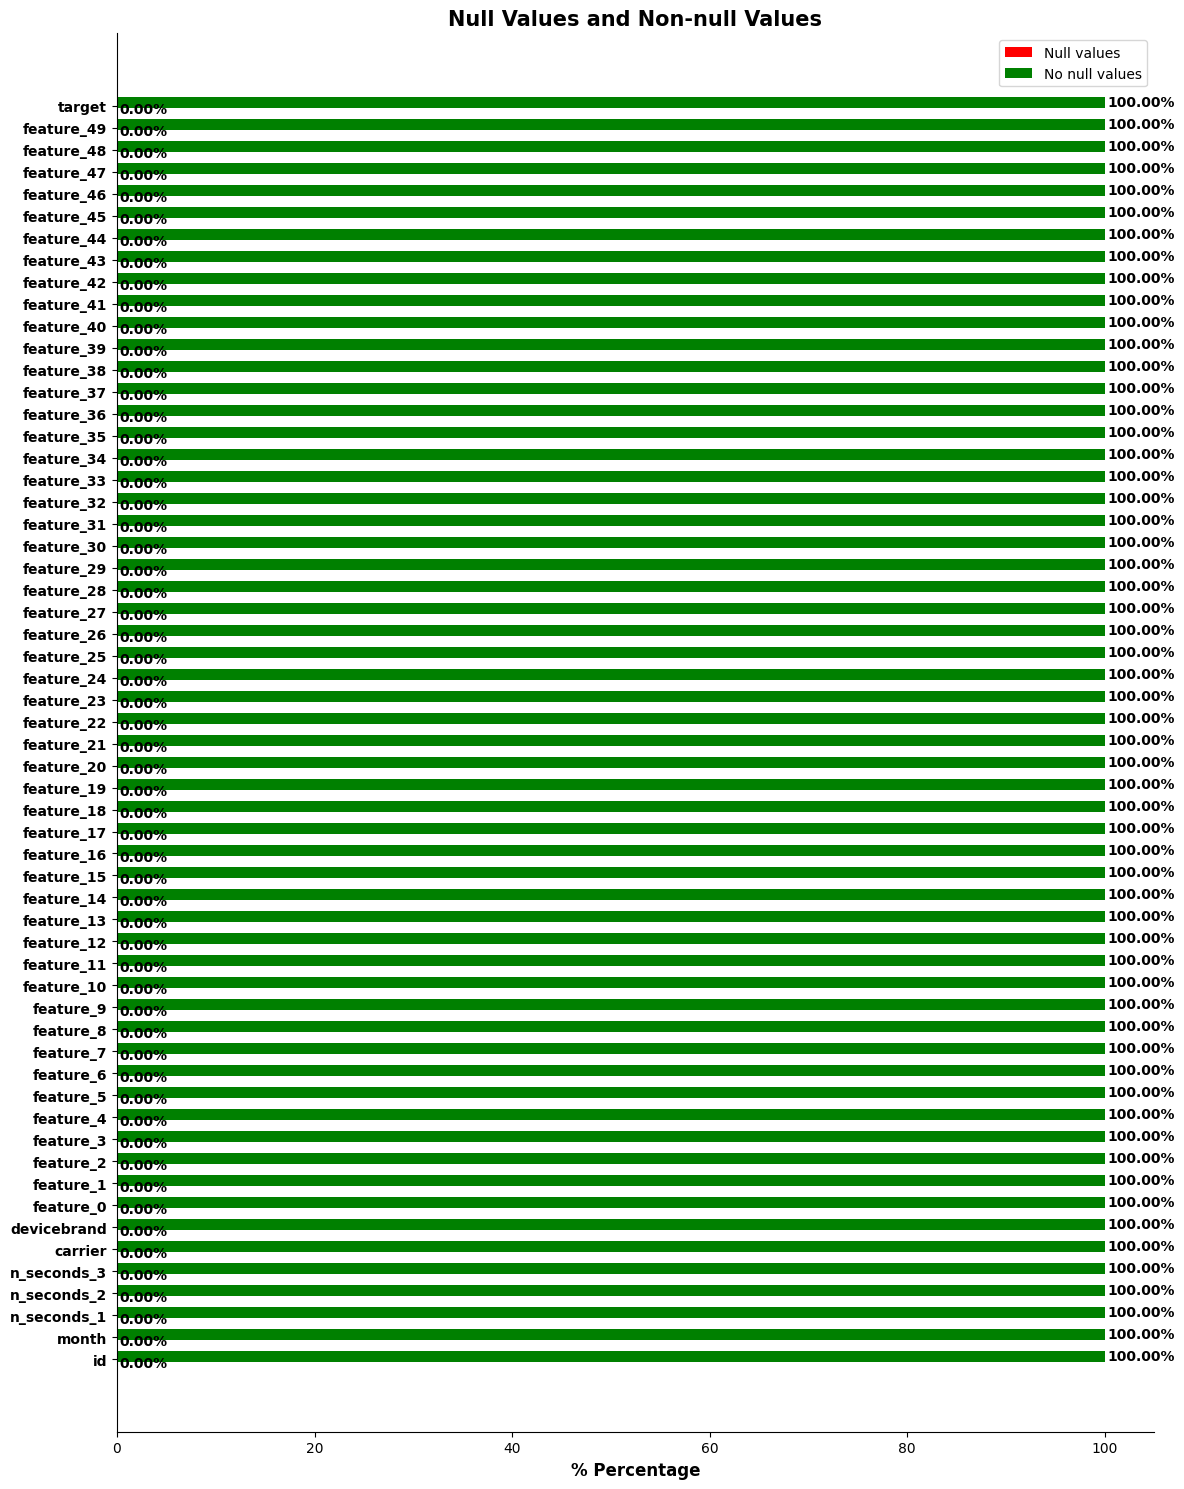

In [8]:
class NullValues:
    def __init__(self, cfg):
        self.cfg = cfg
    
    def process_data(self, dataframe):
        if self.cfg.null_values:
            
            # Calculate the count and percentage of null values in each column
            df_null_values = dataframe.isnull().sum().to_frame().rename(columns={0: 'Count'})
            df_null_values['Percentage_nulls'] = (df_null_values['Count'] / len(dataframe)) * 100
            df_null_values['Percentage_no_nulls'] = 100 - df_null_values['Percentage_nulls']

            # Set up the figure and axes for plotting
            n = len(df_null_values.index)
            x = np.arange(n)
            fig, ax = plt.subplots(figsize=(12, 15))

            bar_width = 0.5
            gap = 0.3

            # Create horizontal bar plots for null and non-null values
            rects1 = ax.barh(x - gap / 2, df_null_values['Percentage_nulls'], bar_width, label='Null values', color='red')
            rects2 = ax.barh(x + gap / 2, df_null_values['Percentage_no_nulls'], bar_width, label='No null values', color='green')

            # Set plot titles, labels, and other properties
            ax.set_title('Null Values and Non-null Values', fontsize=15, fontweight='bold')
            ax.set_xlabel('% Percentage', fontsize=12, fontweight='bold')
            ax.set_yticks(x)
            ax.set_yticklabels(df_null_values.index, fontsize=10, fontweight='bold') 

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.legend()

            # Add percentage labels to the bars
            def autolabel(rects):
                for rect in rects:
                    width = rect.get_width()
                    ax.annotate(f'{width:.2f}%',
                                xy=(width, rect.get_y() + rect.get_height() / 2),
                                xytext=(2, 0),
                                textcoords="offset points",
                                ha='left', va='center', size=10, weight='bold')

            autolabel(rects1)
            autolabel(rects2)

            fig.tight_layout()
            plt.show()
                
        else:
            print("Null Values is disabled. Returning the original dataframes...")
            
        return dataframe

process_null_values = NullValues(CFG())
train = process_null_values.process_data(train)


# **7. Box Plots Analysis**
---
In this section, we perform an analysis of numeric columns in the dataset using box plots. Box plots are a valuable tool for visualizing the distribution, central tendency, and spread of data. They provide insights into the presence of outliers and the overall characteristics of numerical features.


1. **Box Plot Generation**:
   - The function generates box plots for each numeric column in the dataset.


2. **Customization**:
   - Box plots are organized in a grid, making it easy to visualize multiple numeric features simultaneously.


3. **Outlier Detection**:
   - Outliers, if present, can be identified in the box plots, helping to assess data quality and potential anomalies.


4. **Summary Output**:
   - The box plots offer a visual representation of the data distribution for each numeric column. This visualization assists in understanding the data's characteristics and identifying potential outliers.


The box plots analysis is valuable for exploring the distribution of numeric data and identifying any data anomalies. If the box plots analysis is disabled in the configuration settings defined by `CFG()`, the original dataset is returned.

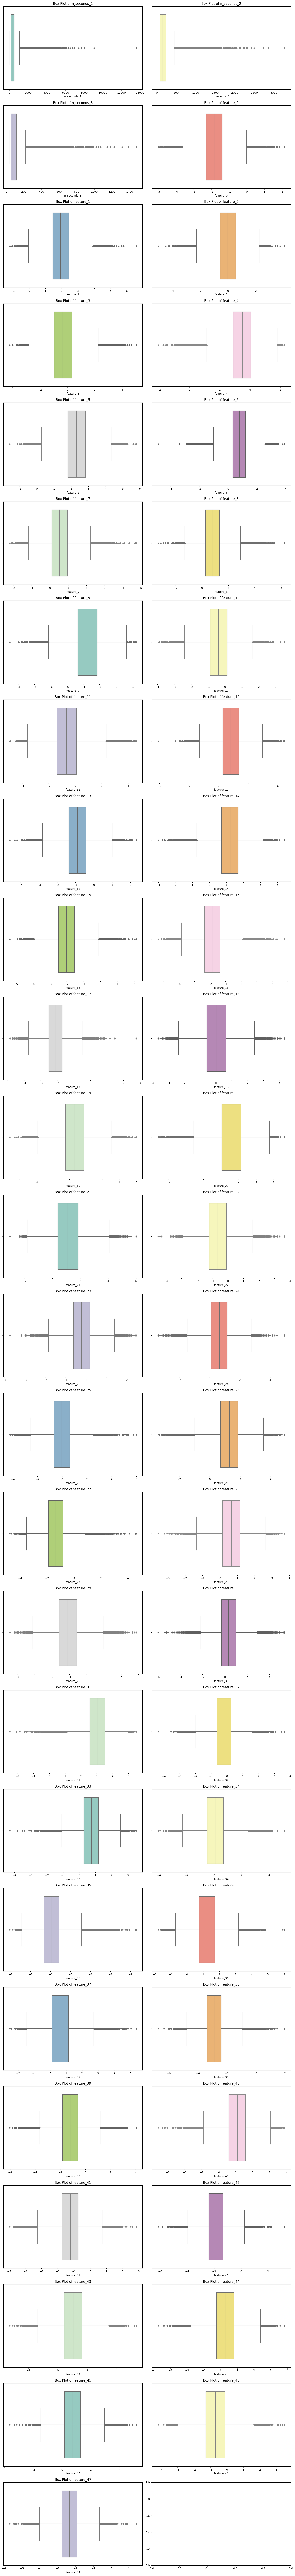

In [9]:
class BoxPlots:
    def __init__(self, cfg):
        self.cfg = cfg
        
    def process_data(self, dataframe, num_cols, n_cols):
        if self.cfg.box_plots:
            
            # Calculate the number of rows needed for the subplots
            nrows = (len(num_cols) + n_cols - 1) // n_cols
            
            # Create a figure and an array of axes for box plots
            fig, axes = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(15, 5 * nrows))

            # Define colors for the box plots
            colors = sns.color_palette('Set3', n_colors=len(dataframe.columns))

            # Iterate through numerical columns and create box plots
            for i, col in enumerate(num_cols):
                if col in dataframe.columns:
                    ax = axes[i // n_cols, i % n_cols]
                    
                    # Create a box plot for the current numerical column
                    sns.boxplot(x=dataframe[col], ax=ax, color=colors[i])
                    ax.set_title(f"Box Plot of {col}")

            plt.tight_layout()
            plt.show()
                
        else:
            print("Box Plots is disabled. Returning the original dataframes...")
            
        return dataframe

process_boxplot = BoxPlots(CFG())
train = process_boxplot.process_data(train, num_cols, 2)


# **8. Histogram Plot Analysis**
---
In this section, we perform an analysis of numeric columns in the dataset using histogram plots. Histograms are a useful tool for visualizing the distribution of numerical data. They provide insights into data patterns, central tendencies, and the presence of peaks or modes.


1. **Histogram Plot Generation**:
   - The function generates histogram plots for each numeric column in the dataset.


2. **Customization**:
   - The histograms are organized in a grid, making it easy to visualize multiple numeric features simultaneously.


3. **Bin Specification**:
   - The number of bins in the histograms can be customized, allowing you to control the level of detail in the visualizations.


4. **Kernel Density Estimation**:
   - The option to include kernel density estimation (KDE) plots along with the histograms enhances the understanding of data distribution.


5. **Summary Output**:
   - The histogram plots provide visual representations of the data distribution for each numeric column. These visualizations help uncover data patterns and central tendencies.

The histogram plot analysis is valuable for exploring the distribution of numeric data and identifying data patterns. If the histogram plot analysis is disabled in the configuration settings defined by `CFG()`, the original dataset is returned.

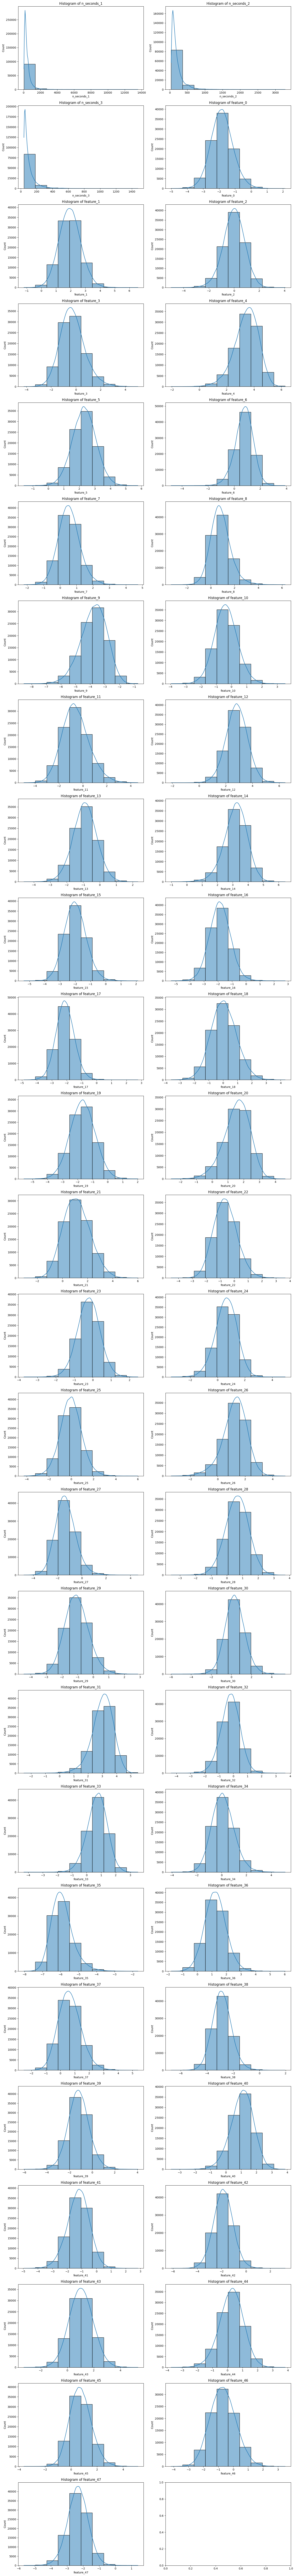

In [10]:
class HistogramPlot:
    def __init__(self, cfg):
        self.cfg = cfg
    
    def process_data(self, dataframe, num_cols, n_cols, bin_num):
        if self.cfg.hist_plots:

            # Calculate the number of rows needed for the subplots
            nrows = (len(num_cols) + n_cols - 1) // n_cols

            # Create a figure and an array of axes for histogram plots
            fig, axes = plt.subplots(nrows=nrows, ncols=n_cols, figsize=(15, 5 * nrows))

            # Iterate through numerical columns and create histogram plots
            for i, col in enumerate(num_cols):
                if col in dataframe.columns:
                    ax = axes[i // n_cols, i % n_cols]

                    # Create a histogram with specified bins and KDE plot
                    sns.histplot(dataframe[col], ax=ax, bins=bin_num, kde=True)
                    ax.set_title(f"Histogram of {col}")

            plt.tight_layout()
            plt.show()
    
        else:
            print("Histogram Plots is disabled. Returning the original dataframes.")
        
        return dataframe

process_hist_plot = HistogramPlot(CFG())
train = process_hist_plot.process_data(train, num_cols, 2, 10)


# **9. Target Variable Visualization**
---
In this section, we visualize the target variable to gain insights into its distribution and composition. The target variable represents the labels or categories assigned to each data point and is a key component of supervised learning tasks.


1. **Data Preparation**:
   - The function preprocesses the target variable, which may contain multiple labels separated by commas.


2. **Unique Categories**:
   - The unique categories present in the target variable are identified. This step is crucial for understanding the composition of the target labels.


3. **Pie Chart**:
   - A pie chart is generated to visualize the distribution of the unique categories within the target variable. The chart displays the percentage of each category in the entire dataset.


4. **Bar Plot**:
   - A bar plot is created to show the count of each unique category. This plot provides a clear view of the frequency of each label in the target variable.


5. **Summary Output**:
   - The pie chart and bar plot facilitate the visualization of the target variable's distribution and composition. These visualizations are valuable for understanding the balance of classes and the frequency of each category.

The target variable visualization is essential for gaining insights into the distribution of labels. It aids in understanding the composition of the target variable and can be useful for tasks such as classification and multi-label classification. If the target variable visualization is disabled in the configuration settings defined by `CFG()`, the original dataset is returned.



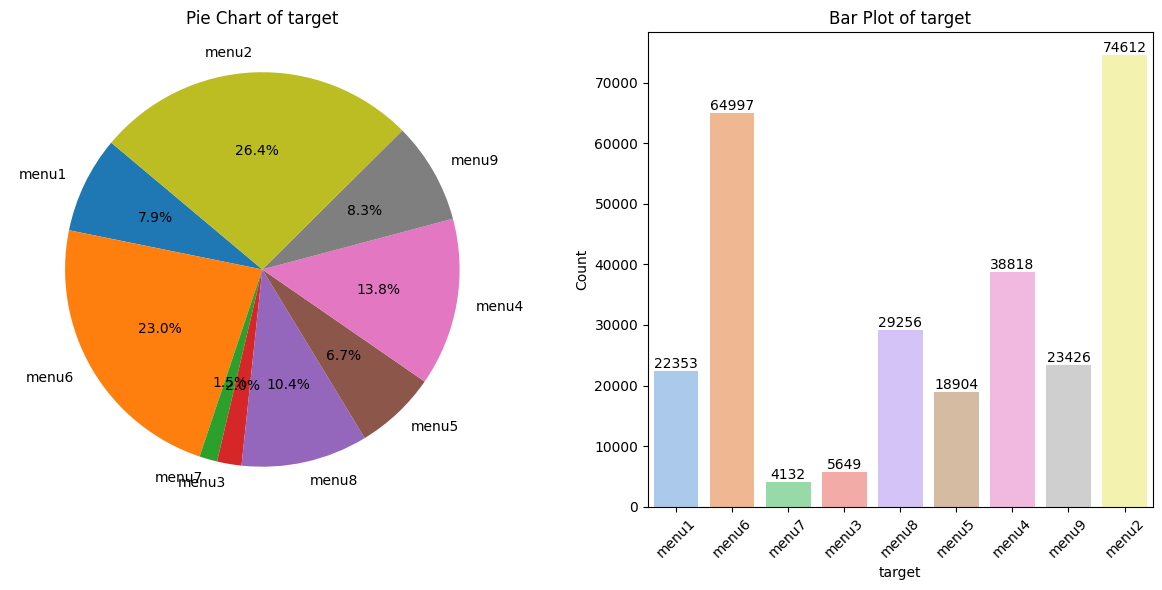

In [11]:
class TargetPlot:
    def __init__(self, cfg):
        self.cfg = cfg
    
    def process_data(self, dataframe, column):
        if self.cfg.target_visualization:
            
            # Split the values in the 'column' by ', ' and convert to a list
            value_lists = dataframe[column].apply(lambda x: x.split(', '))

            # Find unique values across all lists
            unique_values = set()
            for values in value_lists:
                unique_values.update(values)

            # Calculate the total count of unique values
            total_unique_count = len(unique_values)

            # Calculate the percentage of occurrence for each unique value
            percentage = [(value, len([1 for values in value_lists if value in values]) / len(dataframe) * 100)
                          for value in unique_values]

            # Create a dictionary to count occurrences of each unique value
            counts = {}
            for value in unique_values:
                counts[value] = sum(1 for values in value_lists if value in values)

            # Create a figure with two subplots
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))

            # Create a pie chart to visualize percentages
            axes[0].pie([percent for _, percent in percentage], labels=[value for value, _ in percentage], autopct='%1.1f%%', startangle=140)
            axes[0].axis('equal')
            axes[0].set_title(f"Pie Chart of {column}")

            # Create a bar chart to visualize counts
            sns.barplot(x=[value for value in unique_values], y=[counts[value] for value in unique_values], palette='pastel', ax=axes[1])
            axes[1].set_xlabel(column)
            axes[1].set_ylabel('Count')
            axes[1].set_title(f"Bar Plot of {column}")
            axes[1].tick_params(axis='x', rotation=45)

            # Annotate the bar chart with count values
            for index, value in enumerate([counts[value] for value in unique_values]):
                axes[1].text(index, value, str(value), ha='center', va='bottom', fontsize=10)

            plt.tight_layout()
            plt.show()
           
        else:
            print("Target Visualization is disabled. Returning the original dataframes.")
       
        return dataframe

process_target_plot = TargetPlot(CFG())
train = process_target_plot.process_data(train, 'target')


# **10. Menu Usage Visualization**
---
In this section, we explore the relationship between menu items and their corresponding usage times. This analysis provides insights into the usage patterns of different menu items and the amount of time spent on each.


1. **Data Preparation**:
   - The function preprocesses the data, focusing on a target column that contains multiple menu items. The usage times of each menu item are extracted and accumulated.


2. **Usage Time Calculation**:
   - The function calculates the total usage time (in seconds) for each menu item by summing the usage times from multiple columns (e.g., `n_seconds_1`, `n_seconds_2`, `n_seconds_3`).


3. **Pie Chart**:
   - A pie chart is generated to visualize the distribution of total usage times among different menu items. The chart displays the percentage of time spent on each menu item relative to the total usage time.


4. **Summary Output**:
   - The pie chart provides a clear visual representation of menu item usage patterns. It helps identify which menu items are more frequently accessed and the proportion of time dedicated to each.


Menu usage visualization is valuable for understanding user interactions with different menu items and their corresponding usage times. It can be useful for optimizing menu design and identifying user preferences. If menu usage visualization is disabled in the configuration settings defined by `CFG()`, the original dataset is returned.



In [12]:
class MenuUsage:
    def __init__(self, cfg):
        self.cfg = cfg
    
    def process_data(self, dataframe, column):
        if self.cfg.menu_usage:
            
            # Create a dictionary to store menu usage time for each menu item
            menu_usage = {}
            
            # Iterate over the rows in the dataframe
            for index, row in dataframe.iterrows():
                # Split the values in the 'column' by ', ' to get a list of menu items
                targets = row[column].split(', ')
                # Calculate the total usage time for each menu item and update the dictionary
                for target in targets:
                    if target in menu_usage:
                        menu_usage[target] += row['n_seconds_1'] + row['n_seconds_2'] + row['n_seconds_3']
                    else:
                        menu_usage[target] = row['n_seconds_1'] + row['n_seconds_2'] + row['n_seconds_3']

            # Create a DataFrame to store menu usage time data
            usage_df = pd.DataFrame({'Menu': list(menu_usage.keys()), 'Total Usage Time (Seconds)': list(menu_usage.values())})

            # Create a pie chart using Plotly Express
            fig = px.pie(
                usage_df, 
                values='Total Usage Time (Seconds)', 
                names='Menu', 
                title='Menu Usage Times',
                labels={'Total Usage Time (Seconds)': 'Total Usage Time (Seconds)', 'Menu': 'Menus'},
            )

            # Adjust pie chart properties
            fig.update_traces(textposition='outside', textinfo='percent', pull=[0.1] * len(menu_usage)) 
            fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')  
            fig.show()
                
        else:
            print("Menu Usage is disabled. Returning the original dataframes.")
        
        return dataframe

process_menu_usage = MenuUsage(CFG())
train = process_menu_usage.process_data(train, 'target')

# **11. Monthly Menu Usage Visualization**
---
This section explores how menu item usage varies from month to month. It provides insights into how user interactions with different menu items change over time and helps identify any seasonal patterns.


1. **Data Preparation**:
   - The function prepares the data by dividing it into three separate subsets, each corresponding to a different month.


2. **Menu Item Frequency Calculation**:
   - For each month, the function calculates the frequency of menu items in the target column. It identifies how often each menu item is accessed during that specific month.


3. **Bar Chart Creation**:
   - A bar chart is generated to visualize the variations in menu item usage across months. The chart displays the count of each menu item on the y-axis and the menu items themselves on the x-axis. Different months are represented by distinct colors for easy differentiation.


4. **Monthly Comparison**:
   - By examining the bar chart, you can compare the usage patterns of menu items across different months. It helps identify any changes or trends in user interactions.

Monthly menu usage visualization is useful for tracking changes in user behavior over time and can inform decisions related to menu updates or marketing strategies. If monthly menu usage visualization is disabled in the configuration settings defined by `CFG()`, the original dataset is returned.

In [13]:
class MenuUsageMonthly:
    def __init__(self, cfg):
        self.cfg = cfg
    
    def process_data(self, dataframe, target, col):
        if self.cfg.monthly_visualization:
            # Filter data for each month (e.g., October, November, December)
            month_10 = dataframe[dataframe[col] == 10]
            month_11 = dataframe[dataframe[col] == 11]
            month_12 = dataframe[dataframe[col] == 12]

            # Split the 'target' values by ', ' and count occurrences for each unique value
            value_lists_10 = month_10[target].apply(lambda x: x.split(', '))
            value_lists_11 = month_11[target].apply(lambda x: x.split(', '))
            value_lists_12 = month_12[target].apply(lambda x: x.split(', '))

            unique_values = set()
            for values in value_lists_10:
                unique_values.update(values)
            for values in value_lists_11:
                unique_values.update(values)
            for values in value_lists_12:
                unique_values.update(values)

            counts_10 = {value: sum(1 for values in value_lists_10 if value in values) for value in unique_values}
            counts_11 = {value: sum(1 for values in value_lists_11 if value in values) for value in unique_values}
            counts_12 = {value: sum(1 for values in value_lists_12 if value in values) for value in unique_values}

            # Create a bar plot using Plotly Express
            fig = px.bar(x=[value for value in unique_values],
                         labels={target: "Menus", "y": "Count"},
                         title='Bar Plot of Targets for Each Month',)
            
            # Add bars for each month (October, November, December) with different colors
            fig.add_bar(x=[value for value in unique_values], y=[counts_10[value] for value in unique_values],
                        name='October', marker_color='rgb(31, 119, 180)')
            fig.add_bar(x=[value for value in unique_values], y=[counts_11[value] for value in unique_values],
                         name='November', marker_color='rgb(255, 127, 14)')
            fig.add_bar(x=[value for value in unique_values], y=[counts_12[value] for value in unique_values],
                         name='December', marker_color='rgb(44, 160, 44)')

            fig.update_layout(xaxis_tickangle=-45)
            fig.update_layout(height=600)
            fig.show()
    
        else:
            print("Monthly Visualization is disabled. Returning the original dataframes.")

        return dataframe

process_menu_usage = MenuUsageMonthly(CFG())
train = process_menu_usage.process_data(train, 'target', 'month')

# **12. Carrier and Devicebrand Handling**
-------
In this section, we implement data preprocessing techniques to enhance the quality of our dataset for menu recommendation. The primary focus is on handling carriers and device brands, which are crucial aspects of our feature engineering process. Let's break down the key steps within this data preprocessing section:

>#### 1. **Carrier and Devicebrand Removal**

- The `CarrierDiff` class is introduced to manage carrier and devicebrand data.
- The class's `process_data` method takes two dataframes, `dataframe` and `test`, as input, along with a configuration (`CFG`) object.
- If the `remove_carriers` configuration is set to `True`, it proceeds with carrier and devicebrand removal.
- The process involves identifying unique carriers and device brands in both the training and testing datasets.
- Carriers and device brands that exist only in the training data (not in the testing data) are considered for removal.
- The specified columns are dropped from both the `dataframe` and `test` to ensure consistency.
- Duplicate rows are removed based on the feature columns, excluding the target variable.
- If carrier and devicebrand removal is performed, a message is printed to indicate this step.
- The resulting dataframes, `train` and `test`, are returned for further processing.

>#### 2. **Carriers and Devicebrands Handling**

- If the `remove_carriers` configuration is set to `False`, a message is printed to indicate that carrier and devicebrand removal is disabled, and the original dataframes are returned without any changes.

This data preprocessing step plays a crucial role in ensuring data consistency and quality for our machine learning model. It aligns the dataset with the testing data to make accurate menu recommendations based on historical user behavior.


In [14]:
class CarrierDiff:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe, test):
        if self.cfg.remove_carriers:
            # Find unique carriers in training and test data
            unique_carriers_train = set(dataframe['carrier'].unique())
            unique_carriers_test = set(test['carrier'].unique())
            
            # Identify carriers present only in training data and remove them
            train_only_carriers = unique_carriers_train - unique_carriers_test
            dataframe = dataframe[~dataframe['carrier'].isin(train_only_carriers)]
            
            # Find unique device brands in training and test data
            unique_devicebrand_train = set(dataframe['devicebrand'].unique())
            unique_devicebrand_test = set(test['devicebrand'].unique())
            
            # Identify device brands present only in training data and remove them
            train_only_devicebrand = unique_devicebrand_train - unique_devicebrand_test
            dataframe = dataframe[~dataframe['devicebrand'].isin(train_only_devicebrand)]

            # Drop unnecessary columns and remove duplicates
            dataframe = dataframe.drop(["devicebrand", "carrier", "id"], axis=1)
            test = test.drop(["devicebrand", "carrier", "id"], axis=1)
            dataframe = dataframe.drop_duplicates(dataframe.drop("target", axis=1))
            print('Remove some observations from devicebrand and carrier..')

        else: 
            print("Remove carriers is disabled. Returning original dataframe..")

        return dataframe, test

processor_seconds = CarrierDiff(CFG())
train, test = processor_seconds.process_data(train, test)


Remove some observations from devicebrand and carrier..


# **13. Scaling Features**
-------
In this section, we perform feature scaling to ensure that the input features are on a similar scale, which can improve the training and performance of machine learning models.


1. **Feature Scaling**:
   - The selected features in the dataset are scaled to ensure that they have values within a specific range. Min-Max scaling is applied to transform the features.
   


2. **Dataframe Concatenation**:
   - The training and test datasets are concatenated to ensure consistent scaling across both datasets.


3. **Unscaled Feature Exclusion**:
   - Certain features, such as 'target' and 'month,' are excluded from scaling since they do not require normalization.
   


4. **Scaling Transformation**:
   - The selected features are transformed using the Min-Max scaler, ensuring that they fall within the specified feature range (0.05 to 5).
   


5. **Dataframe Split**:
   - The scaled dataset is split back into the original training and test datasets.
   
   

6. **Summary Output**:
   - A message is printed to confirm the completion of the feature scaling process.
   

The feature scaling process aims to normalize features, allowing machine learning models to learn and generalize effectively. The scaled datasets are then used in subsequent modeling steps.

Please note that feature scaling is conditional based on the configuration settings defined in the `CFG()` instance. If scaling is disabled, the original datasets are returned.



In [15]:
class Scaler:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe, test):
        if self.cfg.min_max_scaler:
            
            df = pd.concat([dataframe, test], ignore_index=True)

            unscaled_features = ['target', 'month']
            scaler = MinMaxScaler(feature_range=(0.05, 5))
            df[df.columns.difference(unscaled_features)] = scaler.fit_transform(df[df.columns.difference(unscaled_features)])

            dataframe = df[df["target"].notnull()]
            test = df[df["target"].isnull()]
            test = test.drop('target', axis=1)
            print('Features scaling process is done..')
            
        else: 
            print("Feature scaling is disabled. Returning original dataframe.")

        return dataframe, test

processor_seconds = Scaler(CFG())
train, test = processor_seconds.process_data(train, test)

Features scaling process is done..


# **14. Extracting Seconds Features**
-------
In this section, we focus on enhancing our dataset by extracting seconds-related features. The goal is to derive additional features based on time-related information within the dataset, ultimately contributing to more informative menu recommendations. Let's explore the key steps within this data preprocessing class:


- The `Seconds` class is designed to handle the extraction of seconds-related features from the dataset.
- The class's `process_data` method takes a single dataframe as input, along with a configuration object (`CFG`) that specifies whether to enable feature extraction.
- If the `extract_seconds` configuration is set to `True`, the following operations are performed:

  - Calculation of the total seconds by summing the values of `n_seconds_1`, `n_seconds_2`, and `n_seconds_3`.
  - Normalization of `n_seconds_1`, `n_seconds_2`, and `n_seconds_3` by dividing each by the total seconds.
  - Computation of differences between pairs of seconds-related features (`diff_sc1_sc2`, `diff_sc1_sc3`, and `diff_sc2_sc3`).
  - Creation of a new feature, `MIX`, which combines selected existing features with `total_seconds`.
  
- A message is printed to indicate that seconds features have been successfully extracted.

>#### **Feature Extraction Configuration**

- If the `extract_seconds` configuration is set to `False`, a message is printed to inform that feature extraction is disabled. In this case, the original dataframe is returned without any changes.

The extraction of seconds-related features plays a crucial role in enriching the dataset, making it more informative for our menu recommendation task. By normalizing and deriving new features, we aim to provide better menu suggestions based on users' historical behavior and time-related patterns.


In [16]:
class Seconds:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe):
        if self.cfg.extract_seconds:
            # Calculate and normalize seconds-related features
            dataframe['total_seconds'] = dataframe['n_seconds_1'] + dataframe['n_seconds_2'] + dataframe['n_seconds_3']
            dataframe['n_seconds_1'] = dataframe['n_seconds_1'] / dataframe['total_seconds']
            dataframe['n_seconds_2'] = dataframe['n_seconds_2'] / dataframe['total_seconds']
            dataframe['n_seconds_3'] = dataframe['n_seconds_3'] / dataframe['total_seconds']

            # Calculate additional features based on seconds data
            dataframe['diff_sc1_sc2'] = dataframe['n_seconds_1'] - dataframe['n_seconds_2']
            dataframe['diff_sc1_sc3'] = dataframe['n_seconds_1'] - dataframe['n_seconds_3']
            dataframe['diff_sc2_sc3'] = dataframe['n_seconds_2'] - dataframe['n_seconds_3']
            dataframe['MIX'] = dataframe['feature_0'] + dataframe['feature_31'] + dataframe['feature_11'] + dataframe['total_seconds']
            print("Seconds features extracted..")
            
        else:
            print("Extract seconds is disabled. Returning original dataframe.")
        
        return dataframe

processor_seconds = Seconds(CFG())
train = processor_seconds.process_data(train)
test = processor_seconds.process_data(test)

Seconds features extracted..
Seconds features extracted..


# **15. Extracting Additional Features**
-------
In this section, we aim to further enrich our dataset by extracting additional features. These new features are derived from existing columns, enhancing the dataset's depth and richness for menu recommendation. Let's explore the key operations within this data preprocessing class:


- The `Feature` class is responsible for feature extraction, specifically designed to create additional features.
- The class's `process_data` method takes a single dataframe as input and a configuration object (`CFG`) that controls whether feature extraction is enabled.
- If the `extract_features` configuration is set to `True`, the following feature extraction operations are executed:

  - Identification of specific columns related to differences (`diff_cols`) and feature columns (`ft_cols`) based on their names.
  - Creation of a list of numerical columns (`num_cols`) by combining feature and difference columns.
  - Calculation of several statistical summaries for each row, including:
  
    - Sum of values in the `num_cols`.
    - Mean of values in the `num_cols`.
    - Minimum value in the `num_cols`.
    - Maximum value in the `num_cols`.
    - Standard deviation of values in the `num_cols`.
    - Variance of values in the `num_cols`.
  
  
  - A message is printed to indicate that all features have been successfully extracted.

>#### **Feature Extraction Configuration**

- If the `extract_features` configuration is set to `False`, a message is printed to inform that feature extraction is disabled. In this case, the original dataframe is returned without any changes.

The extraction of additional features contributes to a more comprehensive dataset, providing valuable insights and patterns that can be utilized for menu recommendation. These new features aim to capture relationships and variations within the data for improved model performance.


In [17]:
class Feature:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe):
        if self.cfg.extract_features:
            num_cols = dataframe.select_dtypes(include=['float64', 'int64']).columns

            # Compute various statistics from the selected columns
            dataframe['sum'] = dataframe[num_cols].sum(axis=1)
            dataframe['mean'] = dataframe[num_cols].mean(axis=1)
            dataframe['min'] = dataframe[num_cols].min(axis=1)
            dataframe['max'] = dataframe[num_cols].max(axis=1)
            dataframe['std'] = dataframe[num_cols].std(axis=1)
            dataframe['var'] = dataframe[num_cols].var(axis=1)
            print("All features extracted..")
            
        else:
            print("Extract features is disabled. Returning original dataframe.")
        
        return dataframe

processor_feature = Feature(CFG())
train = processor_feature.process_data(train)
test = processor_feature.process_data(test)

All features extracted..
All features extracted..


# **16. Outlier Detection with Isolation Forest**
-------
In this section, we focus on detecting and handling outliers within the dataset using Isolation Forest, a popular anomaly detection technique. The primary objective is to enhance the data quality for our menu recommendation model by removing potential outliers. Let's explore the key steps within this data preprocessing class:


- The `IForest` class is designed to apply the Isolation Forest algorithm for outlier detection.
- The class's `process_data` method takes a single dataframe as input and a configuration object (`CFG`) that controls whether outlier detection is enabled.
- If the `isolation_forest` configuration is set to `True`, the following operations are executed:

  - Identification of unique target values within the dataset, representing different user preferences.
  - For each unique target value, a subset of the data corresponding to that target value is isolated.
  - The Isolation Forest model is applied to the subset with a contamination rate of 0.03, aiming to identify outliers.
  - Rows classified as outliers are removed from the subset.
  - The data subset is then combined with the main dataset, ensuring that outliers are eliminated.
  - This process is repeated for each unique target value to ensure that outliers are detected and removed comprehensively.



- If the `isolation_forest` configuration is set to `False`, a message is printed to indicate that outlier detection is disabled, and the original dataframe is returned without any changes.

The use of Isolation Forest for outlier detection helps improve data quality and model performance by ensuring that unusual and potentially noisy data points are not considered during the menu recommendation process.


In [18]:
class IForest:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe):
        if self.cfg.isolation_forest:
            # Get unique target values in the dataframe
            unique_targets = dataframe["target"].unique()

            for target_value in unique_targets:
                # Extract data corresponding to the current target value
                data = dataframe[dataframe["target"] == target_value]
                
                # Prepare data for Isolation Forest (remove the target column)
                M = data.drop(["target"], axis=1)

                # Contamination rate is the expected proportion of outliers in the dataset
                IF = IsolationForest(contamination=0.02)

                # Fit the Isolation Forest model to detect outliers in the data
                outlier_mask = IF.fit_predict(M) == -1

                # Remove rows identified as outliers
                data = data[~outlier_mask]

                # Update the original dataframe by removing the rows for the current target value
                # and adding the cleaned data back to it
                dataframe = dataframe[dataframe['target'] != target_value]
                dataframe = pd.concat([dataframe, data], ignore_index=True)

            print("Isolation forest removed some outliers...")
            
        else: 
            print("Isolation Forest is disabled. Returning original dataframe...")

        return dataframe

processor_iforest = IForest(CFG())
train = processor_iforest.process_data(train)

Isolation forest removed some outliers...


# **17. Target Binarization**
-------
In this section, we focus on transforming the target labels in the dataset by binarizing them. The primary goal is to convert multi-label target values into binary representations, making them suitable for menu recommendation prediction. Let's explore the key operations within this data preprocessing class:


- The `Binarizer` class is responsible for converting multi-label target values into binary representations.
- The class's `process_data` method takes a single dataframe as input and a configuration object (`CFG`) that controls whether target binarization is enabled.
- If the `target_binarizer` configuration is set to `True`, the following operations are executed:

  - Utilization of the `MultiLabelBinarizer` to transform the multi-label target values into a binary format.
  - Creation of new binary columns, such as `menu_1`, `menu_2`, ..., `menu_9`, representing the presence or absence of each menu option.
  - Removal of the original target column from the dataset.
  - A message is printed to indicate that the target columns have been successfully binarized.
  - The list of binary menu columns is returned.

>#### **Binarization Configuration**

- If the `target_binarizer` configuration is set to `False`, a message is printed to inform that target binarization is disabled. In this case, the original dataframe is returned without any changes.

The binarization of target columns is crucial for preparing the data for menu recommendation. It simplifies the target labels and makes them compatible with classification models, ultimately leading to more accurate predictions.


In [19]:
# Class for binarizing target labels
class Binarizer:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe):
        if self.cfg.target_binarizer:
            # Create a MultiLabelBinarizer instance
            mlb = MultiLabelBinarizer()
            
            # Define column names for binary-encoded menu columns
            menu_cols = [f'menu_{i}' for i in range(1, 10)]

            # Binarize the 'target' labels by splitting and encoding the comma-separated values
            dataframe[menu_cols] = mlb.fit_transform(dataframe['target'].str.split(', '))

            # Remove the original 'target' column
            dataframe = dataframe.drop('target', axis=1)
            print("Target columns are binarized..")
            
            return dataframe, menu_cols
        else:
            print("Target Binarization is disabled. Returning the original dataframe.")
            return dataframe, None

processor_binarizer = Binarizer(CFG())
train, menu_cols = processor_binarizer.process_data(train)

Target columns are binarized..


# **18. Feature Transformation using Gaussian Mixture Models**
-------
In this section, we focus on transforming the dataset's feature columns using Gaussian Mixture Models (GMM). The primary objective is to extract additional information from the existing features and improve the data's representation for menu recommendation. Let's explore the key operations within this data preprocessing class:


- The `Gaussian` class is designed to apply Gaussian Mixture Models (GMM) to feature columns within the dataset.
- The class's `process_data` method takes the training dataframe, test dataframe, the number of components (`n`), and a list of binary menu columns (`menu_cols`) as inputs. A configuration object (`CFG`) is used to control whether this feature transformation is enabled.
- If the `gaussian_mixture` configuration is set to `True`, the following operations are executed:

  - For each feature column, a GMM model is fitted with `n` components.
  - The GMM predicts the component (class) to which each data point belongs and creates a new column for each feature, such as `feature_0_class`, `feature_1_class`, etc.
  - The same transformations are applied to both the training and test dataframes, enhancing the compatibility between the two datasets.
  - A message is printed to indicate that feature columns have been fitted and extracted.
  - The updated training and test dataframes are returned.

>#### **Gaussian Mixture Models Configuration**

- If the `gaussian_mixture` configuration is set to `False`, a message is printed to inform that feature transformation using GMM is disabled. In this case, the original dataframes are returned without any changes.

The use of Gaussian Mixture Models for feature transformation is beneficial for capturing latent patterns within the feature columns. It enhances the data's representation and can lead to more accurate menu recommendations.


In [20]:
class Gaussian:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe, test, n, menu_cols):
        if self.cfg.gaussian_mixture:
            # Create a Gaussian Mixture Model (GMM) instance with 'n' components and a fixed random state
            gmm = GaussianMixture(n_components=n, random_state=42)
            
            # Extract the feature columns (excluding menu columns)
            feature_cols = [col for col in dataframe.columns if col not in menu_cols]

            # Fit GMM on each feature column and create new columns for the predicted class labels
            for col in feature_cols:
                gmm.fit(dataframe[col].values.reshape(-1, 1))
                dataframe[f'{col}_class'] = gmm.predict(dataframe[col].values.reshape(-1, 1))
                test[f'{col}_class'] = gmm.predict(test[col].values.reshape(-1, 1))
            print("Feature columns are fitted and extracted..")
            
        else:
            print("Gaussian Mixture extraction is disabled. Returning the original dataframes.")
            
        return dataframe, test

processor_gaussian = Gaussian(CFG())
train, test = processor_gaussian.process_data(train, test, 5, menu_cols)

Feature columns are fitted and extracted..


# **19. Predicting Top 3 Menus**
-------
In this section, we present a function that is responsible for generating menu recommendations based on the model's predictions. The primary goal is to predict the top 3 menu options for each user, following binary classification.


The `predictions` function performs the following tasks:

1. **Class Probabilities**: It takes a set of class probabilities as input, which are the model's predictions for each user. These probabilities indicate the likelihood of each menu option being selected.

2. **Top 3 Menus Prediction**:
   - For each user, the function identifies the top 3 menu options with the highest predicted probabilities. These menu options are selected as the recommended menus.
   - The function uses `numpy` to efficiently find the indices of the top 3 probabilities and sets the corresponding positions in the `predicted_classes` array to 1, indicating a recommended menu.
   

3. **Dataframe Creation**: The function assembles the menu recommendations into a pandas DataFrame. Each row of the DataFrame represents a user, and the columns represent the binary representation of the recommended menus (1 indicates recommendation, 0 indicates non-recommendation).

4. **Data Type Conversion**: The predicted classes are converted to integer values for menu columns to create the final recommendations.

5. **Return**: The function returns the DataFrame containing the menu recommendations.

This function plays a crucial role in transforming model predictions into actionable recommendations for users, ensuring that each user is suggested their most relevant menu options.


In [21]:
def predictions(predictions):
    # Input 'predictions' should contain class probabilities
    class_probabilities = predictions
    
    # Define the number of labels to predict (e.g., top 3)
    num_labels_to_predict = 3
    
    # Initialize an array to store the binary predictions
    predicted_classes = np.zeros_like(class_probabilities)
    
    # Iterate through each example to find the top 'num_labels_to_predict' labels
    for i in range(len(class_probabilities)):
        # Find the indices of the top 'num_labels_to_predict' probabilities
        top3_indices = np.argsort(class_probabilities[i])[-num_labels_to_predict:]
        
        # Set the corresponding elements in 'predicted_classes' to 1
        predicted_classes[i, top3_indices] = 1

    data = pd.DataFrame()
    data[menu_cols] = predicted_classes
    data[menu_cols] = data[menu_cols].astype(int)

    return data

# **20. Hyperparameter Optimization with Optuna**
-------
In this section, we perform hyperparameter optimization for three different machine learning models: XGBoost, LightGBM, and CatBoost. The goal is to fine-tune model hyperparameters to maximize the Jaccard Score, which serves as our performance metric for menu recommendation.


1. **Data Preparation**:
   - We begin by splitting the dataset into features (X) and target labels (y). These labels represent the binary preferences for each menu item.
   - The training and testing data are also split with an 80/20 ratio to facilitate hyperparameter tuning.


2. **XGBoost Hyperparameter Optimization**:
   - If the configuration flag `xgb_optuna` is set to True in the `CFG` class, we proceed to optimize the hyperparameters for the XGBoost model.
   - We define an objective function `xgb_objective` for Optuna, which suggests a set of hyperparameters to maximize the Jaccard Score.
   - Optuna is used to conduct a hyperparameter search for XGBoost with constraints on various hyperparameters such as `n_estimators`, `max_depth`, and regularization terms.
   - The best hyperparameters for XGBoost are recorded and printed.


3. **LightGBM Hyperparameter Optimization**:
   - If the configuration flag `lgbm_optuna` is set to True, hyperparameter optimization is performed for the LightGBM model.
   - A similar process as XGBoost is followed, with the definition of the objective function `lightgbm_objective`.
   - Optuna searches for the best hyperparameters for LightGBM, including `max_depth`, `n_estimators`, and more.
   - The best LightGBM hyperparameters are saved and displayed.


4. **CatBoost Hyperparameter Optimization**:
   - If the `catb_optuna` flag is set, we move on to hyperparameter tuning for the CatBoost model.
   - The objective function `catboost_objective` is created for Optuna, specifying hyperparameters like `iterations`, `depth`, and `learning_rate`.
   - Optuna explores various combinations of hyperparameters to maximize the Jaccard Score.
   - The best hyperparameters for CatBoost are stored and printed.


5. **Result Analysis**:
   - Once hyperparameter optimization is completed for the selected models, the best hyperparameters are displayed.
   - Additionally, if a set of hyperparameters is found that significantly improves the model's performance, the Jaccard Score is presented.

This section demonstrates the crucial process of tuning hyperparameters to optimize model performance for menu recommendations. The Jaccard Score is a vital metric to assess the quality of recommendations for users.


In [22]:
class Optuna:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe, menu_cols, trial):
        # Prepare data for modeling
        X = dataframe.drop(menu_cols, axis=1)
        y = dataframe[menu_cols]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

        if self.cfg.xgb_optuna:
            def xgb_objective(trial):
                # Define parameters to optimize
                params = {
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'max_depth': trial.suggest_int('max_depth', 1, 6),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                    "objective": "multi:softmax",
                    "booster": trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
                    "lambda": trial.suggest_loguniform("lambda", 0.1, 1.0),
                    "alpha": trial.suggest_loguniform("alpha", 0.1, 1.0),
                    "verbosity": 0 
                }

                print(f"\nTrial {trial.number} - XGBoost Parameters: {params}")

                # Initialize and train an XGBoost model
                model = LabelPowerset(XGBClassifier(**params))
                model.fit(X_train, y_train)

                # Make predictions on the test set and convert to binary predictions
                y_pred = model.predict_proba(X_test).toarray()
                y_pred = predictions(y_pred)

                # Calculate Jaccard score for model evaluation
                jaccard = jaccard_score(y_test.values, y_pred.values, average='samples')

                return jaccard
                
            
            xgboost_study = optuna.create_study(direction='maximize')
            xgboost_study.optimize(xgb_objective, n_trials=trial)

            best_params_xgboost = xgboost_study.best_params
            print("\nBest Parameters for XGBoost: ", best_params_xgboost)

            return X, y, best_params_xgboost

        if self.cfg.lgbm_optuna:
            def lightgbm_objective(trial):
                # Define parameters to optimize for LightGBM
                params = {
                    'objective': 'multiclassova',
                    'max_depth': trial.suggest_int('max_depth', 1, 6),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
                    'n_estimators': trial.suggest_int('n_estimators', 50, 300),
                    'num_leaves': trial.suggest_int('num_leaves', 2, 50),
                    'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
                    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
                    'verbose': -1
                }

                print(f"\nTrial {trial.number} - LGBM Parameters: {params}")

                # Initialize and train a LightGBM model
                model = LabelPowerset(LGBMClassifier(**params, force_col_wise=True))
                model.fit(X_train, y_train)

                # Make predictions on the test set and convert to binary predictions
                y_pred = model.predict_proba(X_test).toarray()
                y_pred = predictions(y_pred)

                # Calculate Jaccard score for model evaluation
                jaccard = jaccard_score(y_test.values, y_pred.values, average='samples')

                return jaccard
            
            lgbm_study = optuna.create_study(direction='maximize')
            lgbm_study.optimize(lightgbm_objective, n_trials=trial)

            best_params_lightgbm = lgbm_study.best_params
            print("\nBest Parameters for LightGBM: ", best_params_lightgbm)

            return X, y, best_params_lightgbm
        
        if self.cfg.catb_optuna:
            def catboost_objective(trial):
                # Define parameters to optimize for CatBoost
                params = {
                    'objective': 'MultiClass',
                    'iterations': trial.suggest_int('iterations', 50, 300),
                    'depth': trial.suggest_int('depth', 1, 6),
                    'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
                    'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
                    'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
                    'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 20),
                    'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'Poisson']),
                }

                print(f"\nTrial {trial.number} - CatBoost Parameters: {params}")

                # Initialize and train a CatBoost model
                model = LabelPowerset(CatBoostClassifier(**params))
                model.fit(X_train, y_train)

                # Make predictions on the test set and convert to binary predictions
                y_pred = model.predict_proba(X_test).toarray()
                y_pred = predictions(y_pred)

                # Calculate Jaccard score for model evaluation
                jaccard = jaccard_score(y_test.values, y_pred.values, average='samples')

                return jaccard
            
            catb_study = optuna.create_study(direction='maximize')
            catb_study.optimize(catboost_objective, n_trials=trial)

            best_params_catboost = catb_study.best_params
            print("\nBest Parameters for CatBoost: ", best_params_catboost)

            return X, y, best_params_catboost
        
processor_optuna_models = Optuna(CFG())
result = processor_optuna_models.process_data(train, menu_cols, 10)

if result is not None:
    X, y, params = result
else:
    print("None was returned because no condition was satisfied.")

[I 2023-10-17 03:32:34,310] A new study created in memory with name: no-name-3991c8e0-576b-4713-a624-fdafbbb06a02



Trial 0 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 5, 'learning_rate': 0.20661755396278608, 'boosting_type': 'dart', 'n_estimators': 53, 'num_leaves': 4, 'reg_alpha': 0.8855935535035849, 'reg_lambda': 2.171009160465553e-06, 'verbose': -1}


[I 2023-10-17 03:34:33,521] Trial 0 finished with value: 0.5457255589653661 and parameters: {'max_depth': 5, 'learning_rate': 0.20661755396278608, 'boosting_type': 'dart', 'n_estimators': 53, 'num_leaves': 4, 'reg_alpha': 0.8855935535035849, 'reg_lambda': 2.171009160465553e-06}. Best is trial 0 with value: 0.5457255589653661.



Trial 1 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 2, 'learning_rate': 0.021134750517329673, 'boosting_type': 'gbdt', 'n_estimators': 193, 'num_leaves': 36, 'reg_alpha': 0.03014441151067764, 'reg_lambda': 0.36080335580265444, 'verbose': -1}


[I 2023-10-17 03:40:13,972] Trial 1 finished with value: 0.5463009644892591 and parameters: {'max_depth': 2, 'learning_rate': 0.021134750517329673, 'boosting_type': 'gbdt', 'n_estimators': 193, 'num_leaves': 36, 'reg_alpha': 0.03014441151067764, 'reg_lambda': 0.36080335580265444}. Best is trial 1 with value: 0.5463009644892591.



Trial 2 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 2, 'learning_rate': 0.2894407059280072, 'boosting_type': 'gbdt', 'n_estimators': 170, 'num_leaves': 17, 'reg_alpha': 8.135943390096513e-07, 'reg_lambda': 1.162073670345544e-08, 'verbose': -1}


[I 2023-10-17 03:45:17,890] Trial 2 finished with value: 0.5452542744410347 and parameters: {'max_depth': 2, 'learning_rate': 0.2894407059280072, 'boosting_type': 'gbdt', 'n_estimators': 170, 'num_leaves': 17, 'reg_alpha': 8.135943390096513e-07, 'reg_lambda': 1.162073670345544e-08}. Best is trial 1 with value: 0.5463009644892591.



Trial 3 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 6, 'learning_rate': 0.14857617807261556, 'boosting_type': 'dart', 'n_estimators': 151, 'num_leaves': 42, 'reg_alpha': 0.0925917995881816, 'reg_lambda': 0.005091545540469637, 'verbose': -1}


[I 2023-10-17 03:58:43,415] Trial 3 finished with value: 0.5151194651468654 and parameters: {'max_depth': 6, 'learning_rate': 0.14857617807261556, 'boosting_type': 'dart', 'n_estimators': 151, 'num_leaves': 42, 'reg_alpha': 0.0925917995881816, 'reg_lambda': 0.005091545540469637}. Best is trial 1 with value: 0.5463009644892591.



Trial 4 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 1, 'learning_rate': 0.053092821230074326, 'boosting_type': 'dart', 'n_estimators': 150, 'num_leaves': 4, 'reg_alpha': 9.673982587557708e-08, 'reg_lambda': 1.8522372980612238e-07, 'verbose': -1}


[I 2023-10-17 04:03:25,761] Trial 4 finished with value: 0.5126918018412976 and parameters: {'max_depth': 1, 'learning_rate': 0.053092821230074326, 'boosting_type': 'dart', 'n_estimators': 150, 'num_leaves': 4, 'reg_alpha': 9.673982587557708e-08, 'reg_lambda': 1.8522372980612238e-07}. Best is trial 1 with value: 0.5463009644892591.



Trial 5 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 3, 'learning_rate': 0.16951010834327065, 'boosting_type': 'dart', 'n_estimators': 94, 'num_leaves': 18, 'reg_alpha': 0.00026254841067323466, 'reg_lambda': 1.550365043119212e-07, 'verbose': -1}


[I 2023-10-17 04:07:53,292] Trial 5 finished with value: 0.5446679088119246 and parameters: {'max_depth': 3, 'learning_rate': 0.16951010834327065, 'boosting_type': 'dart', 'n_estimators': 94, 'num_leaves': 18, 'reg_alpha': 0.00026254841067323466, 'reg_lambda': 1.550365043119212e-07}. Best is trial 1 with value: 0.5463009644892591.



Trial 6 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 5, 'learning_rate': 0.04477190238677858, 'boosting_type': 'gbdt', 'n_estimators': 207, 'num_leaves': 34, 'reg_alpha': 1.4559390264029737e-08, 'reg_lambda': 0.0011843517787372658, 'verbose': -1}


[I 2023-10-17 04:18:31,565] Trial 6 finished with value: 0.5525920648838228 and parameters: {'max_depth': 5, 'learning_rate': 0.04477190238677858, 'boosting_type': 'gbdt', 'n_estimators': 207, 'num_leaves': 34, 'reg_alpha': 1.4559390264029737e-08, 'reg_lambda': 0.0011843517787372658}. Best is trial 6 with value: 0.5525920648838228.



Trial 7 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 5, 'learning_rate': 0.1135096585178456, 'boosting_type': 'gbdt', 'n_estimators': 279, 'num_leaves': 29, 'reg_alpha': 1.9329255601033072e-08, 'reg_lambda': 0.03811624683579053, 'verbose': -1}


[I 2023-10-17 04:32:18,628] Trial 7 finished with value: 0.5535675142481368 and parameters: {'max_depth': 5, 'learning_rate': 0.1135096585178456, 'boosting_type': 'gbdt', 'n_estimators': 279, 'num_leaves': 29, 'reg_alpha': 1.9329255601033072e-08, 'reg_lambda': 0.03811624683579053}. Best is trial 7 with value: 0.5535675142481368.



Trial 8 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 2, 'learning_rate': 0.1620080462443552, 'boosting_type': 'dart', 'n_estimators': 117, 'num_leaves': 49, 'reg_alpha': 8.870821972777042e-05, 'reg_lambda': 2.5900400085555816e-07, 'verbose': -1}


[I 2023-10-17 04:37:03,354] Trial 8 finished with value: 0.547786058746164 and parameters: {'max_depth': 2, 'learning_rate': 0.1620080462443552, 'boosting_type': 'dart', 'n_estimators': 117, 'num_leaves': 49, 'reg_alpha': 8.870821972777042e-05, 'reg_lambda': 2.5900400085555816e-07}. Best is trial 7 with value: 0.5535675142481368.



Trial 9 - LGBM Parameters: {'objective': 'multiclassova', 'max_depth': 1, 'learning_rate': 0.022033707394384833, 'boosting_type': 'gbdt', 'n_estimators': 263, 'num_leaves': 25, 'reg_alpha': 2.67904131104911e-06, 'reg_lambda': 0.004526402235415323, 'verbose': -1}


[I 2023-10-17 04:43:26,550] Trial 9 finished with value: 0.5399167032003507 and parameters: {'max_depth': 1, 'learning_rate': 0.022033707394384833, 'boosting_type': 'gbdt', 'n_estimators': 263, 'num_leaves': 25, 'reg_alpha': 2.67904131104911e-06, 'reg_lambda': 0.004526402235415323}. Best is trial 7 with value: 0.5535675142481368.



Best Parameters for LightGBM:  {'max_depth': 5, 'learning_rate': 0.1135096585178456, 'boosting_type': 'gbdt', 'n_estimators': 279, 'num_leaves': 29, 'reg_alpha': 1.9329255601033072e-08, 'reg_lambda': 0.03811624683579053}


# **21. XGBoost Classifier**
-------
In this section, we implement the XGBoost classifier to make menu recommendations for users. We explore various strategies of adapting XGBoost to multilabel classification problems using different scikit-multilearn strategies.


1. **Data Split**:
   - The dataset is divided into training and testing sets to facilitate model evaluation. An 80/20 train-test split ratio is employed.
   
   
2. **XGBoost Hyperparameter Setup**:
   - We initiate an XGBoost classifier, considering the specific set of hyperparameters passed to the function.
   
   
3. **Scikit-multilearn Strategies**:
   - The XGBoost classifier is adapted to multilabel classification tasks using four scikit-multilearn strategies: LabelPowerset, ClassifierChain, BinaryRelevance, and OneVsRestClassifier.
   
   
4. **Model Fitting and Prediction**:
   - The XGBoost classifier is fitted to the training data, and predictions are generated for the test set.
   

5. **Performance Evaluation**:
   - For each strategy, we evaluate the model's performance using the Jaccard Score as the metric. The Jaccard Score is a crucial measure to assess the quality of menu recommendations.
   - Predictions are converted into a binary format, where each row indicates the top three recommended menus for a user.
   

6. **Result Analysis**:
   - The Jaccard Score and other relevant information are displayed based on the strategy used for XGBoost adaptation.
   

This section demonstrates the application of XGBoost to the multilabel classification problem of menu recommendation, comparing different scikit-multilearn strategies. The Jaccard Score helps assess the quality of recommendations provided by the XGBoost classifier.


In [23]:
class XGBoost:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, X, y, params):

        if self.cfg.xgb_optuna:

            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Initialize an XGBoost model with the given parameters
            xgb_model = XGBClassifier(**params)
            
            if self.cfg.xgb_classifier_Powerset:
                # Using LabelPowerset multi-label strategy
                print("XGBClassifier executing with LabelPowerset...")
                xgb_model = LabelPowerset(xgb_model, require_dense=[True, True])
                xgb_model.fit(X_train, y_train)
                y_pred = xgb_model.predict_proba(X_test).toarray()

                data = predictions(y_pred)
                jaccard = jaccard_score(y_test.values, data.values, average='samples')

            
            if self.cfg.xgb_classifier_Chain:
                # Using ClassifierChain multi-label strategy
                print("XGBClassifier executing with ClassifierChain...")
                xgb_model = ClassifierChain(xgb_model, order='random', random_state=0)
                xgb_model.fit(X_train, y_train)
                y_pred = xgb_model.predict_proba(X_test)

                data = predictions(y_pred)
                jaccard = jaccard_score(y_test.values, data.values, average='samples')

            
            if self.cfg.xgb_classifier_BRelevance:
                # Using BinaryRelevance multi-label strategy
                print("XGBClassifier executing with BinaryRelevance...")
                xgb_model = BinaryRelevance(xgb_model, require_dense=[True, True])
                xgb_model.fit(X_train, y_train)
                y_pred = xgb_model.predict_proba(X_test).toarray()

                data = predictions(y_pred)
                jaccard = jaccard_score(y_test.values, data.values, average='samples')

            return jaccard, data, xgb_model, X, y
    
processor_xgb_models = XGBoost(CFG())
result = processor_xgb_models.process_data(X, y, params)

if result is not None:
    jaccard, data, model, X, y = result
    print(f'Jaccard score: {jaccard}')
else:
    print("None was returned because no condition was satisfied.")

None was returned because no condition was satisfied.


# **22. LightGBM Classifier**
-------
In this section, we implement the LightGBM classifier to make menu recommendations for users. We explore different strategies for adapting LightGBM to multilabel classification problems using various scikit-multilearn strategies.


1. **Data Split**:
   - The dataset is divided into training and testing sets to facilitate model evaluation. An 80/20 train-test split ratio is employed.
   

2. **LightGBM Hyperparameter Setup**:
   - We initiate a LightGBM classifier, considering the specific set of hyperparameters passed to the function.
   
   
3. **Scikit-multilearn Strategies**:
   - The LightGBM classifier is adapted to multilabel classification tasks using four scikit-multilearn strategies: LabelPowerset, ClassifierChain, BinaryRelevance, and OneVsRestClassifier.
   
   
4. **Model Fitting and Prediction**:
   - The LightGBM classifier is fitted to the training data, and predictions are generated for the test set.
   

5. **Performance Evaluation**:
   - For each strategy, we evaluate the model's performance using the Jaccard Score as the metric. The Jaccard Score is a crucial measure to assess the quality of menu recommendations.
   - Predictions are converted into a binary format, where each row indicates the top three recommended menus for a user.
   

6. **Result Analysis**:
   - The Jaccard Score and other relevant information are displayed based on the strategy used for LightGBM adaptation.
   

This section demonstrates the application of LightGBM to the multilabel classification problem of menu recommendation, comparing different scikit-multilearn strategies. The Jaccard Score helps assess the quality of recommendations provided by the LightGBM classifier.


In [24]:
class LGBM:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self):

        if self.cfg.lgbm_optuna:

            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Initialize an LGBM model with the given parameters
            lgbm_model = LGBMClassifier(**params, verbose=-1, force_col_wise=True)

            if self.cfg.lgbm_classifier_Powerset:
                # Using LabelPowerset multi-label strategy
                print("LGBMClassifier executing with LabelPowerset...")
                lgbm_model = LabelPowerset(lgbm_model, require_dense=[True, True])
                lgbm_model.fit(X_train, y_train)
                y_pred = lgbm_model.predict_proba(X_test).toarray()

                data = predictions(y_pred)
                jaccard = jaccard_score(y_test.values, data.values, average='samples')

            
            if self.cfg.lgbm_classifier_Chain:
                # Using ClassifierChain multi-label strategy
                print("LGBMClassifier executing with ClassifierChain...")
                lgbm_model = ClassifierChain(lgbm_model, order='random', random_state=0)
                lgbm_model.fit(X_train, y_train)
                y_pred = lgbm_model.predict_proba(X_test)
                
                data = predictions(y_pred)
                jaccard = jaccard_score(y_test.values, data.values, average='samples')

                
            if self.cfg.lgbm_classifier_BRelevance:
                # Using BinaryRelevance multi-label strategy
                print("LGBMClassifier executing with BinaryRelevance...")
                lgbm_model = BinaryRelevance(lgbm_model, require_dense=[True, True])
                lgbm_model.fit(X_train, y_train)
                y_pred = lgbm_model.predict_proba(X_test).toarray()
                
                data = predictions(y_pred)
                jaccard = jaccard_score(y_test.values, data.values, average='samples')

            return jaccard, data, lgbm_model, X, y
    
processor_lgm_models = LGBM(CFG())
result = processor_lgm_models.process_data()

if result is not None:
    jaccard, data, model, X, y = result
    print(f'Jaccard score: {jaccard}')
else:
    print("None was returned because no condition was satisfied.")

LGBMClassifier executing with BinaryRelevance...
Jaccard score: 0.5601545374835598


# **23. CatBoost Classifier**
-------
In this section, we implement the CatBoost classifier for making menu recommendations to users. Similar to the LightGBM classifier section, we explore different strategies using scikit-multilearn to adapt CatBoost to the multilabel classification problem.


1. **Data Split**:
   - The dataset is divided into training and testing sets to facilitate model evaluation, following an 80/20 train-test split ratio.
   

2. **CatBoost Hyperparameter Setup**:
   - A CatBoost classifier is initiated with specific hyperparameters for multi-class classification.
   
   
3. **Scikit-multilearn Strategies**:
   - The CatBoost classifier is adapted for multilabel classification using four scikit-multilearn strategies: LabelPowerset, ClassifierChain, BinaryRelevance, and OneVsRestClassifier.
   
   
4. **Model Fitting and Prediction**:
   - The CatBoost classifier is fitted to the training data, and predictions are generated for the test set.
   

5. **Performance Evaluation**:
   - For each strategy, the model's performance is assessed using the Jaccard Score as the primary metric. The Jaccard Score is a vital measure for evaluating the quality of menu recommendations.
   

6. **Result Analysis**:
   - The Jaccard Score and other relevant information are displayed, depending on the strategy used to adapt CatBoost.
   

This section showcases the application of CatBoost for multilabel classification, providing menu recommendations to users. We compare the performance of CatBoost using different scikit-multilearn strategies, with the Jaccard Score as the key evaluation metric.


In [25]:
class CatBoost:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, X, y, params):

        if self.cfg.catb_optuna:

            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Initialize a CatBoost classifier with specified hyperparameters
            catb_clf = CatBoostClassifier(**params)
                    
            if self.cfg.catb_classifier_Powerset:
                # Using LabelPowerset multi-label strategy
                print("CatBoostClassifier executing with LabelPowerset...")
                catb_model = LabelPowerset(catb_clf, require_dense=[True, True])
                catb_model.fit(X_train, y_train)
                y_pred = catb_model.predict_proba(X_test).toarray()

                data = predictions(y_pred)
                jaccard = jaccard_score(y_test.values, data.values, average='samples')


            if self.cfg.catb_classifier_Chain:
                # Using ClassifierChain multi-label strategy
                print("CatBoostClassifier executing with ClassifierChain...")
                catb_model = ClassifierChain(catb_clf, order='random', random_state=0)
                catb_model.fit(X_train, y_train)
                y_pred = catb_model.predict_proba(X_test)

                data = predictions(y_pred)
                jaccard = jaccard_score(y_test.values, data.values, average='samples')


            if self.cfg.catb_classifier_BRelevance:
                # Using BinaryRelevance multi-label strategy
                print("CatBoostClassifier executing with BinaryRelevance...")
                catb_model = BinaryRelevance(catb_clf, require_dense=[True, True])
                catb_model.fit(X_train, y_train)
                y_pred = catb_model.predict_proba(X_test).toarray()
                
                data = predictions(y_pred)
                jaccard = jaccard_score(y_test.values, data.values, average='samples')

            return jaccard, data, catb_model, X, y
        
processor_catb_models = CatBoost(CFG())
result = processor_catb_models.process_data(X, y, params)

if result is not None:
    jaccard, data, model, X, y = result
    print(f'Jaccard score: {jaccard}')
else:
    print("None was returned because no condition was satisfied.")


None was returned because no condition was satisfied.


# **24. Cross Validation**
-------
In this section, we implement cross-validation to assess the performance of our models. Cross-validation is a robust technique for evaluating the generalization of machine learning models. In this context, we use it to determine the effectiveness of our multilabel classification models in menu recommendation.


1. **Cross-Validation Strategy**:
   - Cross-validation is employed with Multilabel Stratified K-Fold, which takes into account the multilabel nature of the problem.
   

2. **Model Fitting and Prediction**:
   - For each fold, the model is fitted to the training data and predictions are generated for both the training and validation sets. 
   

3. **Performance Evaluation**:
   - The Jaccard Score is computed for both the training and validation sets to evaluate model performance on each fold.
   

4. **Result Analysis**:
   - The Jaccard Scores for each fold, as well as the average training and validation scores, are presented. These scores provide insights into the model's stability and its ability to generalize to unseen data.
   

5. **Summary Statistics**:
   - The section concludes with the average training and validation scores, offering a summary of the model's overall performance.
   

This section leverages cross-validation to evaluate the performance of our multilabel classification models. It allows us to assess how well our models generalize to unseen data and provides a robust measure of their effectiveness in making menu recommendations to users.


In [26]:
class CrossValidation:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, X, y, split, bool, model):
        # Check if cross-validation is enabled in the configuration
        if self.cfg.cross_validation:
            # Display information about the model and cross-validation settings
            print(f'Cross Validation is executing for {type(model).__name__}-{type(model.classifier).__name__}\n')
            # Initialize cross-validation with Multilabel Stratified K-Fold
            cv = MultilabelStratifiedKFold(n_splits=split, shuffle=bool, random_state=0)
            train_scores = []
            val_scores = []
            split_count = 0

            # Perform cross-validation
            for train_idx, test_idx in cv.split(X, y):
                split_count += 1

                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

                model.fit(X_train, y_train)

                train_preds = model.predict_proba(X_train).toarray()
                train_pred_data = predictions(train_preds)
                
                val_preds = model.predict_proba(X_test).toarray()
                test_pred_data = predictions(val_preds)

                train_jaccard_score = jaccard_score(y_train.values, train_pred_data.values, average='samples')
                val_jaccard_score = jaccard_score(y_test.values, test_pred_data.values, average='samples')

                # Print the Jaccard scores for each split
                print(f'{split_count}.split -> train Jaccard score: {train_jaccard_score}     validation Jaccard score: {val_jaccard_score}')

                train_scores.append(train_jaccard_score)
                val_scores.append(val_jaccard_score)

            # Calculate and display the average training and validation scores
            average_train_score = np.mean(train_scores)
            average_val_score = np.mean(val_scores)  
              
            return average_train_score, average_val_score, model
            

processor_cv_models = CrossValidation(CFG())
result = processor_cv_models.process_data(X, y, 10, True, model)

if result is not None:
    average_train_score, average_val_score, model = result
    print(f'\nAverage Training Score: {average_train_score:.3f}')
    print(f'Average Validation Score: {average_val_score:.3f}')
else:
    print("None was returned because no condition was satisfied.")


Cross Validation is executing for BinaryRelevance-LGBMClassifier

1.split -> train Jaccard score: 0.6358832846003899     validation Jaccard score: 0.5578602620087335
2.split -> train Jaccard score: 0.6361276108866061     validation Jaccard score: 0.5571334214002642
3.split -> train Jaccard score: 0.6357010710808179     validation Jaccard score: 0.5612334801762114
4.split -> train Jaccard score: 0.6359898674980515     validation Jaccard score: 0.5596516213847503
5.split -> train Jaccard score: 0.6363068188740391     validation Jaccard score: 0.5612621465225461
6.split -> train Jaccard score: 0.6364020609766495     validation Jaccard score: 0.5530460461555288
7.split -> train Jaccard score: 0.6363440283684487     validation Jaccard score: 0.5593222185899531
8.split -> train Jaccard score: 0.635017584851472     validation Jaccard score: 0.5572074556082497
9.split -> train Jaccard score: 0.6360819596289172     validation Jaccard score: 0.5540650406504064
10.split -> train Jaccard score: 0.

# **25. Test Prediction**

In this section, we make predictions on the test dataset using the trained model and generate a submission file in the required format for the Kaggle competition. This process is essential for evaluating the model's performance on unseen data and preparing the results for submission.


1. **Model Prediction on Test Data**:
   - The trained model is used to make predictions on the test dataset, which contains features related to menu items.
   

2. **Submission File Creation**:
   - The predictions are converted into the appropriate submission format, which typically involves encoding binary labels for multiple menu items. The submission file is saved in the required format for the Kaggle competition.
   

3. **Submission File Output**:
   - The submission file is saved with a name such as 'submit.parquet', and it includes the predicted labels for the test data.
   

4. **Summary Statistics**:
   - A summary of the submission file is provided, including the count of unique target labels. This offers insights into the distribution of predictions.
   

This section completes the machine learning pipeline by generating predictions for the test dataset. It prepares the results in a format that can be submitted to the Kaggle competition for evaluation. The section ends with a summary of the submission file, showing the distribution of predicted labels.


In [27]:
class TestPrediction:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, model, X, y, test, sub_name):
        # Check if test prediction is enabled in the configuration
        if self.cfg.predict_test:
            # Display information about the model being used for test predictions
            print(f'Code is executing with {type(model).__name__}-{type(model.classifier).__name__} for Test.. \n')

            # Fit the model with training data and predict the test data
            model.fit(X, y)
            y_pred = model.predict_proba(test).toarray()
            y_pred_data = predictions(y_pred)
            
            # Generate submission predictions and save them to a Parquet file
            submission['target'] = y_pred_data.apply(lambda row: ''.join(map(str, row)), axis=1)
            submission.to_parquet(f'{sub_name}.parquet', index=False)
            
            return submission

processor_cv_models = TestPrediction(CFG())
result = processor_cv_models.process_data(model, X, y, test, 'submit')

if result is not None:
    submission = result
    # Display value counts of the 'target' column in the submission
    print(submission.target.value_counts())
else:
    print("None was returned because no condition was satisfied.")


Code is executing with BinaryRelevance-LGBMClassifier for Test.. 

target
010101000    7435
010011000    1046
110001000     834
010001001     676
010110000     582
010100001     329
110100000     277
010001010     276
000111000     192
010100010     101
110000001      35
010001100      34
010010001      32
000011001      21
000101001      16
110010000      12
100101000      10
100001001       8
010000011       7
010010010       5
000110001       5
110000010       3
000011100       3
010100100       3
000101100       2
100010001       2
010010100       2
011001000       1
010000110       1
011100000       1
100011000       1
000011010       1
100001100       1
111000000       1
Name: count, dtype: int64
